In [454]:
#Standards
import os
import numpy as np
import pandas as pd
import string
from collections import deque



#Plots
%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns



# classifiers / models
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR



# Data, preprocessing and pipeline

#Pro
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)


# metrics for class imbalance
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix, 
    plot_confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)


# hyperparameter optimization

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)

# other
# ignore warning 
import warnings
warnings.filterwarnings('ignore')


In [407]:
bank_add_full = pd.read_csv("../data/raw/bank-additional-full.csv", sep=';')

df = bank_add_full

In [409]:
df2 = df.copy()
df2.loc[df['y'] == 'no', 'target'] = 0
df2.loc[df['y'] == 'yes', 'target'] = 1

In [410]:
train_df, test_df = train_test_split(df2, test_size = 0.20, random_state=123)

In [411]:
numeric_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", 
                    "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed", "duration"]
categorical_features = ["job", "poutcome", "month", "day_of_week", "contact","marital", "default", "housing", "loan"]
ordinal_features = ["education"]
education_ordering = ['illiterate', 'basic.4y','basic.6y','basic.9y','high.school',
            'professional.course','university.degree', 'unknown']
drop_features = ["y"]
target = ["target"]

In [412]:
X_train = train_df.drop(columns=target)
y_train = train_df[target]
X_test = test_df.drop(columns=target)
y_test = test_df[target]

In [268]:
numeric_transformer = make_pipeline(       
    SimpleImputer(strategy="median"), 
    StandardScaler()   
    )  
ordinal_transformer = make_pipeline(       
    SimpleImputer(strategy="most_frequent"),       
    OrdinalEncoder(categories=[education_ordering])   
    )   
categorical_transformer = make_pipeline(       
    SimpleImputer(strategy="constant", fill_value="missing"),       
    OneHotEncoder(handle_unknown="ignore", sparse=False)  
    )

In [413]:


preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (categorical_transformer, categorical_features)
)

In [255]:
# A function to store mean cross-validation validation values 
def store_cross_val_results(model_name, scores, results_dict):
    results_dict[model_name] = {
        "accuracy": "{:0.4f}".format(np.mean(scores["test_accuracy"])),
#         "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),   #since it's not critical to get the result within an hour or so, fit and score time would not matter much
#         "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "recall": "{:0.4f}".format(np.mean(scores["test_recall"])),
        "precision": "{:0.4f}".format(np.mean(scores["test_precision"])),
        "f1": "{:0.4f}".format(np.mean(scores["test_f1"])),
        "AP": "{:0.4f}".format(np.mean(scores["test_average_precision"])),
        "roc_auc": "{:0.4f}".format(np.mean(scores["test_roc_auc"])),
    }

In [416]:
results_df = {}

In [417]:
scoring=["accuracy", "f1", "recall", "precision", "average_precision", "roc_auc"] 
pipe = make_pipeline(preprocessor, DummyClassifier(strategy="most_frequent"))
scores = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring=scoring)
summary = store_cross_val_results("Dummy", scores, results_df)
pd.DataFrame(results_df)

,Dummy
AP,0.1123
accuracy,0.8877
f1,0.0000
precision,0.0000
recall,0.0000
roc_auc,0.5000


In [418]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "RBF SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),  #max_iter=2000
    "Logistic Regression (balanced)": LogisticRegression(class_weight="balanced"),  #max_iter=2000,
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Random Forest (balanced)": RandomForestClassifier(class_weight="balanced")
}

In [420]:
for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    summary = store_cross_val_results(model_name, scores, results_df)
model_selection = pd.DataFrame(results_df).T  

In [423]:
model_selection.to_html('../data/model_selection.html', justify = "center")
model_selection

,accuracy,recall,precision,f1,AP,roc_auc
Dummy,0.8877,0.0000,0.0000,0.0000,0.1123,0.5000
Decision Tree,0.8885,0.5281,0.5035,0.5154,0.3190,0.7311
RBF SVM,0.9084,0.3635,0.6703,0.4712,0.6127,0.9200
Naive Bayes,0.8100,0.6535,0.3270,0.4358,0.3870,0.8277
Logistic Regression,0.9105,0.4211,0.6595,0.5138,0.5906,0.9334
Logistic Regression (balanced),0.8591,0.8789,0.4369,0.5836,0.5827,0.9360
Ridge Classifier,0.9062,0.3211,0.6723,0.4345,0.5944,0.9324
Random Forest,0.9121,0.4557,0.6577,0.5382,0.6348,0.9400
Random Forest (balanced),0.9109,0.4054,0.6716,0.5054,0.6303,0.9406


In [424]:
pipe_lr_balance = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced"))

In [425]:
param_grid = {
    "logisticregression__C": 10.0 ** np.arange(-3, 3),
    "logisticregression__max_iter": np.arange(200,2000,200),
}
random_search = RandomizedSearchCV(pipe_lr_balance, param_distributions=param_grid, n_jobs=-1, n_iter=30, cv=5, scoring = "f1", verbose=1)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   41.0s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['y']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'emp.var.rate',
                                                                                'cons.price.idx',
                                                                                'cons.conf.idx',
                                                                                'euribor3m',
                                                                                'nr.emplo...
                                                                                'day_of_week',
                                                                                'contact',
                                                                                'marital',
                                                                                'default',
                                                                                'housing',
                                                                                'loan'])])),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced'))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'logisticregression__max_iter': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800])},
                   scoring='f1', verbose=1)

In [440]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))


hyper_opt_result = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_logisticregression__C",
        "param_logisticregression__max_iter",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().reset_index().head(5)



hyper_opt_result.rename(columns= {'mean_test_score':'f1', 'rank_test_score':'rank'}, inplace=True)
hyper_opt_result

hyper_opt_result.to_html('../data/hyperparameter_optimization_result.html', justify = "center")


Best hyperparameter values:  {'logisticregression__max_iter': 200, 'logisticregression__C': 1.0}
Best score: 0.584


In [441]:
# pipeline for best model with optimized hyperparameters

pipe_lr_best = random_search.best_estimator_
pipe_lr_best.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['y']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed', 'duration']),
                                                 ('pipeline-2',
                                                  Pi...
                                                  ['education']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['job', 'poutcome', 'month',
                                                   'day_of_week', 'contact',
                                                   'marital', 'default',
                                                   'housing', 'loan'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

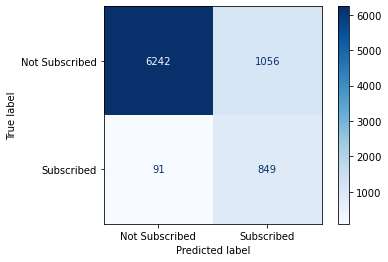

In [498]:
# Plot confusion matrix
cm = plot_confusion_matrix(pipe_lr_best, X_test, y_test, display_labels=["Not Subscribed", "Subscribed"], values_format="d", cmap=plt.cm.Blues)


path2 = "../data/confusion_matrix.png"
plt.savefig(path2)

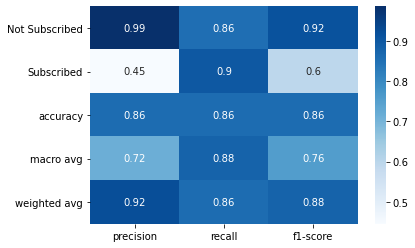

In [497]:
# Classification report

c_report = classification_report(y_test, pipe_lr_best.predict(X_test), target_names=["Not Subscribed", "Subscribed"], output_dict=True)
report_df = pd.DataFrame(c_report)



cr_plot = sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="Blues")

path3 = "../data/classification_report.png"
fig = cr_plot.get_figure()
fig.savefig(path3)

In [482]:
weights = pipe_lr_best.named_steps['logisticregression'].coef_.flatten()
ohe_c_features = list(pipe_lr_best.named_steps['columntransformer']\
                       .named_transformers_['pipeline-3'].named_steps['onehotencoder']\
                       .get_feature_names(categorical_features))
transformed_columns = numeric_features + ordinal_features + ohe_c_features2

In [501]:
data2={'Predictors':transformed_columns, 'Coefficient':weights}
feature_importance = pd.DataFrame(data)

In [502]:
feature_importance["abs"] = abs(feature_importance_original["coefficient"])

feature_importance_top10 = feature_importance.sort_values(by="abs", ascending=False).nlargest(10,'abs')
feature_importance_top10 

feature_importance_top10.to_html('../data/hyperparameter_optimization_result.html', justify = "center")


In [503]:
plot = alt.Chart(feature_importance_top10)\
            .mark_bar()\
            .encode(x=alt.X("abs", scale=alt.Scale(domain=(0, 4)),title="Feature Coefficients"),
                    y=alt.Y("features", sort="-x", title="Features"))
    

In [448]:
# plot

alt.Chart(...)

In [500]:
path = "../data/top10_features.svg"
plot.save(path)